In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.model_selection._split import check_cv
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.externals import six
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


from skimage.io import imread
from skimage import img_as_float

import pickle

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from keras.applications.xception import Xception, preprocess_input as xception_preprocess_input

import face_recognition

import time

from PIL import Image

#progress bar
from ipywidgets import FloatProgress
from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns



pd.set_option('display.max_columns', 40)
%matplotlib inline  

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_colwidth',100)

In [152]:
username = 'ShchegolevMaximMaximovich'

# Конечная модель

В данной работе вкратце написаны шаги для получения итоговой модели.

![alt text](final_model.png "Title")

# Данные

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_id = train_data['Id']
test_id = test_data['Id']

train_y = train_data['Target']

for data in [train_data, test_data]:
    data.drop(['Id'], axis=1, inplace=True)

train_data.head(3)

,Target,Duration,Language,Country,Rating,Action,Adventure,Animation,Biography,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,Poster
0,0,139,English,France,PG-13,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.jpg
1,0,90,English,USA,R,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.jpg
2,0,103,Mandarin,China,R,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.jpg


In [149]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 27 columns):
Target         3635 non-null int64
Duration       3635 non-null int64
Language       3629 non-null object
Country        3635 non-null object
Rating         3522 non-null object
Action         3635 non-null int64
Adventure      3635 non-null int64
Animation      3635 non-null int64
Biography      3635 non-null int64
Crime          3635 non-null int64
Documentary    3635 non-null int64
Drama          3635 non-null int64
Family         3635 non-null int64
Fantasy        3635 non-null int64
History        3635 non-null int64
Horror         3635 non-null int64
Music          3635 non-null int64
Musical        3635 non-null int64
Mystery        3635 non-null int64
News           3635 non-null int64
Romance        3635 non-null int64
Sci-Fi         3635 non-null int64
Sport          3635 non-null int64
Thriller       3635 non-null int64
War            3635 non-null int64
Western        

In [18]:
print('shape: ', train_data.shape)

shape:  (3635, 27)


**Выборка несбалансированна**

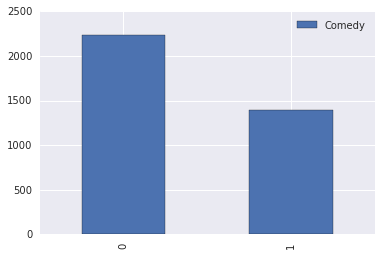

In [14]:
train_data['Target'].value_counts().plot(kind='bar', label='Comedy')
plt.legend()

**Можно наглядно показать, что комедии в среднем короче**

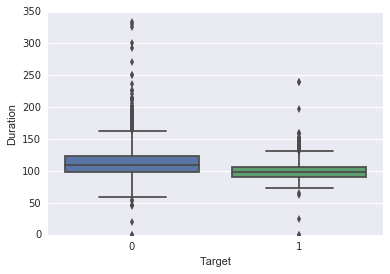

In [15]:
sns.boxplot(x='Target', y=train_data['Duration'], data=train_data)

**Количество фильмов по рейтингам для обучающей и тестовой выборки**

In [20]:
train_data['Rating'].value_counts()

R            1601
PG-13        1111
PG            530
G              86
Not Rated      80
Approved       40
Unrated        38
Passed          8
X               7
NC-17           5
TV-G            5
TV-14           4
GP              4
M               2
TV-MA           1
Name: Rating, dtype: int64

In [21]:
test_data['Rating'].value_counts()

R            407
PG-13        266
PG           125
G             20
Not Rated     20
Unrated       14
Approved      12
X              4
NC-17          2
GP             2
M              1
Passed         1
Name: Rating, dtype: int64

**Страны которые есть в тестовой выборке, но которых нет в обучающей**

In [38]:
set(test_data['Country'].value_counts().keys()) - set(train_data['Country'].value_counts().keys())

{'Libya', 'Panama'}

**Языки которые есть в тестовой выборке, но которых нет в обучающей**

In [41]:
set(test_data['Language'].value_counts().keys()) - set(train_data['Language'].value_counts().keys())

{'Vietnamese'}

# Эволюция моделей

Будем делать кросс-валидацию разбивая исходную выборку на 10 частей.

In [3]:
kfold_10 = KFold(n_splits=10,shuffle=True,random_state=42)

## 1 Самая простая модель

In [46]:
x_1_columns = ['Duration', 'Action',
       'Adventure', 'Animation', 'Biography', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
train_x_1  = train_data[x_1_columns]
test_x_1 = test_data[x_1_columns]

**Логистическая регрессия**

Для логистической регрессии данные нужно нормализовать

In [48]:
def get_scaled(train, test=None):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train)
    if test is None:
        return scaled_train
    
    scaled_test = scaler.transform(test)
    
    return scaled_train, scaled_test

кросс-валидация одной строчкой

In [12]:
def get_cv_results(params, model, kfold,train,train_y, test=None,test_y=None):
    gscv=GridSearchCV(model,params,cv=kfold,scoring='roc_auc')
    gscv.fit(train, train_y)
    
    return pd.DataFrame(gscv.cv_results_)[['params','mean_test_score','std_test_score']]

In [59]:
scaled_train_x_1, scaled_test_x_1 = get_scaled(train_x_1, test_x_1)
lr_params_1={'C':[0.1,1,10],'max_iter':[500],'solver':['newton-cg', 'lbfgs', 'liblinear'], 'class_weight':['balanced']}
get_cv_results(lr_params_1, LogisticRegression(), kfold_10, scaled_train_x_1, train_y)

,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'max_iter': 500, 'solver': 'newton-cg', 'class_weight': 'balanced'}",0.881009,0.019845
1,"{'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs', 'class_weight': 'balanced'}",0.881010,0.019847
2,"{'C': 0.1, 'max_iter': 500, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.881009,0.019850
3,"{'C': 1, 'max_iter': 500, 'solver': 'newton-cg', 'class_weight': 'balanced'}",0.880983,0.019861
4,"{'C': 1, 'max_iter': 500, 'solver': 'lbfgs', 'class_weight': 'balanced'}",0.880983,0.019861
5,"{'C': 1, 'max_iter': 500, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.880966,0.019873
6,"{'C': 10, 'max_iter': 500, 'solver': 'newton-cg', 'class_weight': 'balanced'}",0.880947,0.019867
7,"{'C': 10, 'max_iter': 500, 'solver': 'lbfgs', 'class_weight': 'balanced'}",0.880944,0.019867
8,"{'C': 10, 'max_iter': 500, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.880942,0.019865


**Градиентный бустинг**

In [65]:
gb_params_1 = {'n_estimators':[80, 110, 150,250],'max_depth':[3,5,7]}
gb_1_gscv = GridSearchCV(GradientBoostingClassifier(random_state=42),gb_params_1,cv=kfold_10,scoring='roc_auc')
gb_1_gscv.fit(train_x_1,train_y)
pd.DataFrame(gb_1_gscv.cv_results_)[['params','mean_test_score','std_test_score']]

,params,mean_test_score,std_test_score
0,"{'max_depth': 3, 'n_estimators': 80}",0.884423,0.024543
1,"{'max_depth': 3, 'n_estimators': 110}",0.884875,0.024555
2,"{'max_depth': 3, 'n_estimators': 150}",0.885140,0.023816
3,"{'max_depth': 3, 'n_estimators': 250}",0.883674,0.023812
4,"{'max_depth': 5, 'n_estimators': 80}",0.884117,0.023867
5,"{'max_depth': 5, 'n_estimators': 110}",0.882538,0.024111
6,"{'max_depth': 5, 'n_estimators': 150}",0.880879,0.024407
7,"{'max_depth': 5, 'n_estimators': 250}",0.875907,0.024237
8,"{'max_depth': 7, 'n_estimators': 80}",0.877446,0.023248
9,"{'max_depth': 7, 'n_estimators': 110}",0.872819,0.023666


## 2 Модель с кодированием категориальных признаков

### dummy кодирование

Для dummy кодирования объединим обучающую и тестовую выборку(есть значения категориальных признаков, которые есть в тестовой выборке, но которых нет в обучающей выборке)

In [71]:
def get_dummies(train, test, columns):
    train_data_length= len(train)
    full_data = pd.concat(objs=[train, test], axis=0)
    for column in columns:
        full_data = pd.concat([full_data, pd.get_dummies(full_data[column])],axis=1)
        full_data.drop(column, axis=1, inplace=True)
    
    train = full_data.iloc[:train_data_length]
    test = full_data.iloc[train_data_length:]
    
    return train, test

In [97]:
train_x_2_1, test_x_2_1 = get_dummies(train_data, test_data, ['Rating','Language','Country'])

for data in [train_x_2_1, test_x_2_1]:
    data.drop(['Target', 'Poster'], axis=1, inplace=True)

**Логистическая регрессия**

In [78]:
scaled_train_x_2_1, scaled_test_x_2_1 = get_scaled(train_x_2_1, test_x_2_1)
get_cv_results(lr_params_1, LogisticRegression(), kfold_10, scaled_train_x_2_1, train_y)

,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'max_iter': 500, 'solver': 'newton-cg', 'class_weight': 'balanced'}",0.876740,0.017697
1,"{'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs', 'class_weight': 'balanced'}",0.876727,0.017710
2,"{'C': 0.1, 'max_iter': 500, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.876811,0.017690
3,"{'C': 1, 'max_iter': 500, 'solver': 'newton-cg', 'class_weight': 'balanced'}",0.874749,0.016770
4,"{'C': 1, 'max_iter': 500, 'solver': 'lbfgs', 'class_weight': 'balanced'}",0.874748,0.016736
5,"{'C': 1, 'max_iter': 500, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.874608,0.016823
6,"{'C': 10, 'max_iter': 500, 'solver': 'newton-cg', 'class_weight': 'balanced'}",0.873174,0.016533
7,"{'C': 10, 'max_iter': 500, 'solver': 'lbfgs', 'class_weight': 'balanced'}",0.873144,0.016391
8,"{'C': 10, 'max_iter': 500, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.873159,0.016512


**Градиентный бустинг**

In [79]:
get_cv_results(gb_params_1, GradientBoostingClassifier(random_state=42), kfold_10, train_x_2_1, train_y)

,params,mean_test_score,std_test_score
0,"{'max_depth': 3, 'n_estimators': 80}",0.884814,0.025909
1,"{'max_depth': 3, 'n_estimators': 110}",0.886367,0.025040
2,"{'max_depth': 3, 'n_estimators': 150}",0.886992,0.024687
3,"{'max_depth': 3, 'n_estimators': 250}",0.886770,0.024676
4,"{'max_depth': 5, 'n_estimators': 80}",0.885194,0.025925
5,"{'max_depth': 5, 'n_estimators': 110}",0.885042,0.024969
6,"{'max_depth': 5, 'n_estimators': 150}",0.883643,0.024850
7,"{'max_depth': 5, 'n_estimators': 250}",0.878964,0.023771
8,"{'max_depth': 7, 'n_estimators': 80}",0.882301,0.025857
9,"{'max_depth': 7, 'n_estimators': 110}",0.881421,0.024787


Попробуем другое кодирование

### кодирование с оглядкой на целевую переменную

Будем кодировать категориальные признаки так, что в них будет содержаться процентное соотношение числа комедий в обучающей выборке с данным значением.

In [5]:
def comedy_count_encoding(train, test, columns):
    train = train.copy()
    test = test.copy()
    
    for column in columns:
        column_to_comedy_count_dict = (train[train['Target']==1].groupby(column).size()/train.groupby(column).size()).fillna(0)

        for data in [train,test]:
            data[column]=data[column].map(column_to_comedy_count_dict)
            nan_rows_total_count = train[column].isnull().sum()
            nan_rows_comedy_count = len(train[(train[column].isnull()) &(train['Target']==1)])
        
            na_filler = (0 if nan_rows_total_count==0 else nan_rows_comedy_count/nan_rows_total_count)
            data[column] = data[column].fillna(na_filler)
        
    return train, test

Когда выполнялась эта работа, путем проб и ошибок(постепенное добавление признаков) было выяснено, что от страны лучше отказаться.  
В этом документе будем сразу кодировать рейтинг и язык

In [6]:
train_x_2_2, test_x_2_2 = comedy_count_encoding(train_data, test_data, ['Rating','Language'])

for data in [train_x_2_2, test_x_2_2]:
    data.drop(['Country','Poster'], axis=1, inplace=True)
train_x_2_2.drop(['Target'],axis=1,inplace=True)

In [107]:
get_cv_results(gb_params_1, GradientBoostingClassifier(random_state=42), kfold_10, train_x_2_2, train_y)

,params,mean_test_score,std_test_score
0,"{'max_depth': 3, 'n_estimators': 80}",0.887177,0.023484
1,"{'max_depth': 3, 'n_estimators': 110}",0.888747,0.023742
2,"{'max_depth': 3, 'n_estimators': 150}",0.888963,0.023599
3,"{'max_depth': 3, 'n_estimators': 250}",0.887673,0.022663
4,"{'max_depth': 5, 'n_estimators': 80}",0.888729,0.024249
5,"{'max_depth': 5, 'n_estimators': 110}",0.887777,0.023915
6,"{'max_depth': 5, 'n_estimators': 150}",0.885591,0.022906
7,"{'max_depth': 5, 'n_estimators': 250}",0.881638,0.021543
8,"{'max_depth': 7, 'n_estimators': 80}",0.882920,0.023343
9,"{'max_depth': 7, 'n_estimators': 110}",0.879288,0.022747


результаты несколько улучшились

## 3 Извлечение цветов из постеров

1. Используем knn для нахождения 8 средних цветов на каждом постере.  
2. К полученным данным еще раз применим knn, но уже для нахождения 12 основных цветов всех постеров.   
3. После, для каждого фильма получим вектор размерности 12, который будет представлять количественное соотношение основных цветов на постере.(У фильма могут быть цвета, которые не попадут в основные) 

In [39]:
def get_image_for_knn(image_path):
    return img_as_float(imread(image_path))

In [126]:
def get_mean_colours(image, n_clusters = 8):
    x = image.reshape(image.shape[0]*image.shape[1],3)
    kmeans = KMeans(random_state=241, n_clusters=n_clusters)
    kmeans.fit(x)
    clusters = [x[kmeans.labels_==cl] for cl in range(n_clusters)]
    clusters.sort(key=lambda tup: tup.shape[0], reverse=True)
    means = np.array([np.hstack([np.mean((c),axis=0), c.shape[0]/x.shape[0]]) for c in clusters])

    return means

In [124]:
def get_mean_colour_for_data(data, n_clusters=8):
    #progress bar
    fp = FloatProgress(min=0, max = len(data), bar_style='success')
    display(fp)
    
    features = np.empty((len(data),n_clusters,4))
    
    for i in data.index:
        image_path = 'posters/{0}'.format(data.iloc[i]['Poster'])
        features[i] = np.array(get_mean_colours(get_image_for_knn(image_path),n_clusters))
        fp.value = i+1
        
    return features.reshape(-1,4)

In [120]:
def get_colour_features(train, test, n_clusters=12, random_state=241):
    colour_kmeans = KMeans(random_state=random_state, n_clusters=n_clusters)
    colour_kmeans.fit(train[:,:3])
    
    train_values= np.array([colour_kmeans.labels_, train[:,3]]).transpose()
    test_values= np.array([colour_kmeans.predict(test[:,:3]), test[:,3]]).transpose()
    
    def get_features(data_values):
        features = np.empty((len(data_values)//8, n_clusters))
        for i,poster in enumerate(data_values.reshape(-1,8,2)):
            feature = np.zeros(n_clusters)
            for colour in poster:
                feature[int(colour[0])]=colour[1]
            features[i] = feature
        return features
            
    train_features = get_features(train_values)
    test_features = get_features(test_values)
        
    return train_features,test_features

In [127]:
train_mean_colours = get_mean_colour_for_data(train_data)
test_mean_colours = get_mean_colour_for_data(test_data)

train_image_12_colours, test_image_12_colours = get_colour_representation(train_mean_colours, test_mean_colours)
pickle.dump(train_image_12_colours, open( "train_image_12_colors_one_hot.p", "wb" ) )
pickle.dump(test_image_12_colours, open( "test_image_12_colors_one_hot.p", "wb" ) )

In [157]:
train_image_12_colours = pickle.load( open( "train_image_12_colors_one_hot.p", "rb" ) )
test_image_12_colours = pickle.load( open( "test_image_12_colors_one_hot.p", "rb" ) )

In [158]:
train_image_12_colours[0]

array([ 0.27739052,  0.05400197,  0.05531409,  0.21114893,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.08936772,
        0.06796375,  0.        ])

In [8]:
# train_x_6_4 , test_x_6_4 in BaseModel
train_x_3_1 = np.hstack((train_x_2_2, train_image_12_colours))
test_x_3_1 = np.hstack((test_x_2_2, test_image_12_colours))

In [70]:
get_cv_results({'n_estimators':[100,150]}, GradientBoostingClassifier(random_state=52), kfold_10, train_x_3_1, train_y)

,params,mean_test_score,std_test_score
0,{'n_estimators': 100},0.891383,0.023888
1,{'n_estimators': 150},0.891510,0.022595


## 4 Определение количества лиц на постере

Узнаем количество лиц на каждом постере. Для распознавания лиц на постере будем использовать библиотеку
[face_recognition](https://github.com/ageitgey/face_recognition)

In [56]:
def get_target_size(image_size, new_image_size):
    """Helper for get_image """
    base_ratio = image_size[0]/image_size[1]
    if new_image_size[0]/new_image_size[1]< base_ratio:
        #vertical fitting
        target_size = (new_image_size[0],new_image_size[0]/base_ratio)
    else:
        #horizontal fitting
        target_size = (new_image_size[1]*base_ratio,new_image_size[1])
    result = np.ceil(target_size).astype('int')

    return result
def get_image(image_path, new_image_size, save_ratio=True, expand=False):
    result = None
    if save_ratio:
        #empty space will be filled by background
        target_size = get_target_size((268,182),new_image_size)
        img = image.load_img(image_path, target_size=(target_size[0],target_size[1]))
        x = image.img_to_array(img)
        
        background = (np.ones((new_image_size[0],new_image_size[1],3))*150)
        background[:x.shape[0],:x.shape[1],:] = x
        result = background
    else:
        #the image is stretched
        img = image.load_img(image_path, target_size=new_image_size)
        result = image.img_to_array(img)
        if expand:
            result = np.expand_dims(result, axis=0)
    return result

def get_count_of_faces(image_path,factor = 3):
#     image = face_recognition.load_image_file(image_path)
    image=get_image(image_path,(factor*268,factor*182),save_ratio=True).astype('int8')
    faces= face_recognition.face_locations(image,model='cnn')
    
    return len(faces)


def get_face_count_features(data, image_size=(3*268,3*182),save_ratio=True):
    #progress bar
    fp = FloatProgress(min=0, max = len(data), bar_style='success')
    display(fp)
    
    features = np.empty(len(data))
    
    for i in data.index:
        image_path = 'posters/{0}'.format(data.iloc[i]['Poster'])
        image = get_image(image_path, image_size, save_ratio).astype('int8')
        faces= face_recognition.face_locations(image,model='cnn')
        features[i] = len(faces)
        fp.value = i+1
        
    return features.astype('int')

Рассмотрим для примера второй постер

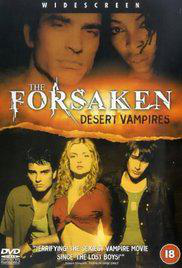

In [22]:
image_2 = face_recognition.load_image_file("posters/2.jpg")
Image.fromarray(image_1)

Если использовать картинку в исходном размере 268x182

In [25]:
print('найдено лиц: {0}'.format(get_count_of_faces("posters/2.jpg", factor=1)))

найдено лиц: 2


Если же **картинку масштабировать**, то количество найденных лиц вырастет. Используем множитель равный трём (т.е 804x546)

In [26]:
print('найдено лиц: {0}'.format(get_count_of_faces("posters/2.jpg", factor=3)))

найдено лиц: 5


Получим признаки для обучающей и тестовой выборки

In [32]:
train_count_of_faces = get_face_count_features(train_data)
test_count_of_faces = get_face_count_features(test_data)
# pickle.dump(train_count_of_faces , open( "train_count_of_faces.p", "wb" ) )
# pickle.dump(test_count_of_faces , open( "test_count_of_faces.p", "wb" ) )

# train_count_of_faces = pickle.load(open('train_count_of_faces.p','rb'))
# test_count_of_faces= pickle.load(open('test_count_of_faces.p','rb'))

Посмотрим на постеры и на предсказанное количество лиц на этих постерах

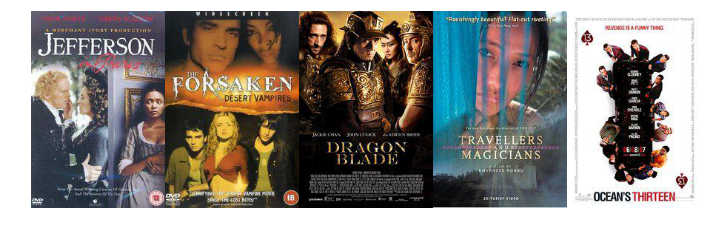

Количество лиц на первых пяти постерах:  [3 5 4 0 0]


In [52]:
images = [get_image_for_knn('posters/{0}.jpg'.format(i)) for i in range(1,6)]

fig = plt.figure(1, (12., 6.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,5),
                 axes_pad=0,
)

for i in range(5):
    grid[i].imshow(images[i])
    grid[i].axis('off')
plt.show(block=True)
print('Количество лиц на первых пяти постерах: ',train_count_of_faces[:5])

С первыми тремя постерами все хорошо, но на четвертом и пятом постере сеть не смогла найти лица.  
С четвертым постером проблема скорее всего в том, что лицо перекрывается синими линиями, а с пятым - слишком низкое разрешение.

In [63]:
train_x_4_1 = np.hstack([train_x_3_1, np.expand_dims(train_count_of_faces,axis=1)])
test_x_4_1 = np.hstack([test_x_3_1, np.expand_dims(test_count_of_faces,axis=1)])

In [68]:
get_cv_results({'n_estimators':[100,150]}, GradientBoostingClassifier(random_state=52), kfold_10, train_x_4_1, train_y)

,params,mean_test_score,std_test_score
0,{'n_estimators': 100},0.892580,0.024063
1,{'n_estimators': 150},0.892318,0.022646


Есть некоторое улучшение, но в конечном итоге лучше использовать следующий подход

## 5 Нейронные сети

Будем использовать готовую нейронную сеть для классификации изображений.  
Дальше есть два варианта:  
1. Обрубить последние слои и использовать выход сети как набор признаков
2. Обрубить последние слои и заменить своими слоями, после чего обучить сеть  

Со вторым вариантом все сложнее, т.к нет гпу для обучения, поэтому для начала используем первый вариант.

In [75]:
def get_model_output(model, preprocess, image):
    x = preprocess(image)
    feature = model.predict(x)
    
    return feature

def get_neural_network_features(data, model, preprocess,image_size=(268,182),save_ratio=True):
    #progress bar
    fp = FloatProgress(min=0, max = len(data), bar_style='success')
    display(fp)
    
    image_shape = (1, image_size[0], image_size[1], 3)
    #feature_shape is constant when include_top=True
    feature_shape = np.product(model.compute_output_shape(image_shape))
    features = np.empty((len(data), feature_shape))
    
    for i in data.index:
        image_path = 'posters/{0}'.format(data.iloc[i]['Poster'])
        image = get_image(image_path, image_size, save_ratio,True)
        features[i] = get_model_output(model, preprocess, image).reshape(feature_shape)
        fp.value = i+1
        
    return features

В данном разделе используем vgg19.  

vgg19 принимает на вход изображения размерности 224x224, поэтому нужно было либо растянуть изображение до квадрата, либо изменить размер с сохранением масштаба самого изображения и заполнением пустого пространства некоторым фоном.  Для этого была написана функция get_image,которая была объявлена в четвертом пункте.  Значительной разницы между двумя подходами замечено небыло, в работе используется подход с растягиванием изображения.  

Также нужно было определиться со слоем, с которого доставать выходные значения-признаки. Чем ближе слой к выходу, тем больше выход заточен под конкретную задачу, на которую тренировалась нейронка. Чем ближе слой к началу, тем менее сложные представления он может передать. Выбор слоя можно рассматривать как настройку параметров алгоритма.

In [61]:
vgg19_full_model = VGG19(weights='imagenet', include_top=True)
vgg19_fc1 = Model(inputs=vgg19_full_model.input, outputs=vgg19_full_model.get_layer('fc1').output)
vgg19_fc2 = Model(inputs=vgg19_full_model.input, outputs=vgg19_full_model.get_layer('fc2').output)

vgg19_fc2_train_features = get_neural_network_features(train_data, vgg19_fc2, vgg19_preprocess_input,(224,224),False)
vgg19_fc2_test_features = get_neural_network_features(test_data, vgg19_fc2, vgg19_preprocess_input,(224,224),False)
# pickle.dump(vgg19_fc2_train_features , open( "train_image_vgg19_fc2_224x224_features.p", "wb" ) )
# pickle.dump(vgg19_fc2_test_features , open( "test_image_vgg19_fc2_224x224_features.p", "wb" ) )

vgg19_fc1_train_features = get_neural_network_features(train_data, vgg19_fc1, vgg19_preprocess_input,(224,224),False)
vgg19_fc1_test_features= get_neural_network_features(test_data, vgg19_fc1, vgg19_preprocess_input,(224,224),False)
# pickle.dump(vgg19_fc1_train_features , open( "train_image_vgg19_fc1_224x224_features.p", "wb" ) )
# pickle.dump(vgg19_fc1_test_features , open( "test_image_vgg19_fc1_224x224_features.p", "wb" ) )


# vgg19_fc2_train_features = pickle.load(open('train_image_vgg19_fc2_224x224_features.p','rb'))
# vgg19_fc2_test_features = pickle.load(open('test_image_vgg19_fc2_224x224_features.p','rb'))
# vgg19_fc1_train_features= pickle.load(open('train_image_vgg19_fc1_224x224_features.p','rb'))
# vgg19_fc1_test_features= pickle.load(open('test_image_vgg19_fc1_224x224_features.p','rb'))

In [9]:
# vgg19_fc1_train_features= pickle.load(open('train_image_vgg19_fc1_224x224_features.p','rb'))
# vgg19_fc1_test_features= pickle.load(open('test_image_vgg19_fc1_224x224_features.p','rb'))

Запустим кросс-валидацию без использования остальных признаков.

In [18]:
#fc2
get_cv_results({'n_estimators':[200]}, GradientBoostingClassifier(random_state=52), KFold(n_splits=3,random_state=42,shuffle=True), vgg19_fc2_train_features, train_y)

,params,mean_test_score,std_test_score
0,{'n_estimators': 200},0.827337,0.005336


In [19]:
#fc1
get_cv_results({'n_estimators':[200]}, GradientBoostingClassifier(random_state=52), KFold(n_splits=3,random_state=42,shuffle=True), vgg19_fc1_train_features, train_y)

,params,mean_test_score,std_test_score
0,{'n_estimators': 200},0.834174,0.007858


Будем использовать fc_1 слой для генерации признаков.

Соберем воедино все признаки и посмотрим значение на кросс-валидации:

In [35]:
train_x_5_1 =  np.hstack([train_x_3_1, vgg19_fc1_train_features])
test_x_5_1 =  np.hstack([test_x_3_1, vgg19_fc1_test_features])

In [45]:
get_cv_results({'n_estimators':[250]}, GradientBoostingClassifier(random_state=52), KFold(n_splits=5,random_state=42,shuffle=True), train_x_5_1, train_y)

,params,mean_test_score,std_test_score
0,{'n_estimators': 250},0.903149,0.012431


Можно настроить параметры и тем самым улучшить результат, но в рамках этого отчета перейдем к следующему шагу(На ноутбуке все считается медленно)

In [79]:
get_cv_results({'n_estimators':[100]}, GradientBoostingClassifier(random_state=52), KFold(n_splits=5,random_state=42,shuffle=True), train_x_5_1, train_y)

,params,mean_test_score,std_test_score
0,{'n_estimators': 100},0.902219,0.013949


## 6 Ансамбли

Идея в том, чтобы использовать ответы нескольких алгоритмов для улучшения результата. 

### Умное усреднение

Можно было бы использовать следующий подход

Модели выдают вероятности принадлежности объекта к классу, но выдавать эти вероятности они могут несколько по разному. 0.7 у одного алгоритма и 0.7 у другого - могут быть совершенно разными вещами. 
Отсортируем, выставим ранги, нормализуем ранги. Полученныее числа и будут нашими предсказаниями для конкретной модели.  

In [41]:
def rank_and_normalize(array):
    if type(array)!=np.ndarray:
        array = np.array(array)
    temp = array.argsort()
    ranks = np.empty(len(array), int)
    ranks[temp] = np.arange(len(array))
    result = ranks/np.max(ranks)
    
    return result

In [42]:
#usage example
rank_and_normalize([0.5, 0.7, 1, 0.1])

array([ 0.33333333,  0.66666667,  1.        ,  0.        ])

После чего уже можно усреднять ответы моделей. Подход был опробован, но дал худшие результаты нежели чем стекинг.

### Стекинг

Возьмём Xception, VGG19,InceptionV3 - нейронные сетки для классификации изображений и прогоним через них изображения, откинув при этом последнии слои этих моделей(см. пункт 5 для примера).  Тем самым мы получим набор признаков характеризующих постеры. Добавим признаки полученные в первых трёх пунктах, после чего запустим стекинг. 

Признаки с использованием vgg19 были получены в пятом пункте

In [48]:
inception_full_model = InceptionV3(weights='imagenet')
inception_avg_pool = Model(inputs=inception_full_model.input, outputs=inception_full_model.get_layer('avg_pool').output)

In [70]:
inception_avg_pool_train_features = get_neural_network_features(train_data, inception_avg_pool, inception_preprocess_input,(299,299),False)
# pickle.dump(inception_avg_pool_train_features, open( "train_image_inception_avg_pool_299_299_broken_ratio_features.p", "wb" ) )
inception_avg_pool_test_features = get_neural_network_features(test_data, inception_avg_pool, inception_preprocess_input,(299,299),False)
# pickle.dump(inception_avg_pool_test_features, open( "test_image_inception_avg_pool_299_299_broken_ratio_features.p", "wb" ) )

# inception_avg_pool_train_features= pickle.load( open( 'train_image_inception_avg_pool_299_299_broken_ratio_features.p', "rb" ) )
# inception_avg_pool_test_features = pickle.load( open( 'test_image_inception_avg_pool_299_299_broken_ratio_features.p', "rb" ) ) 

In [72]:
xception_full_model = Xception(weights='imagenet', include_top=True)
xception_avg_pool = Model(inputs=xception_full_model.input, outputs=xception_full_model.get_layer('avg_pool').output)

In [77]:
xception_avg_pool_train_features = get_neural_network_features(train_data, xception_avg_pool, xception_preprocess_input,(299,299),False)
# pickle.dump(xception_avg_pool_train_features, open( "train_image_xception_avg_pool_299_299_padding_features.p", "wb" ) )
xception_avg_pool_test_features = get_neural_network_features(test_data, xception_avg_pool, xception_preprocess_input,(299,299),False)
# pickle.dump(xception_avg_pool_test_features, open( "test_image_xception_avg_pool_299_299_padding_features.p", "wb" ) )

# xception_avg_pool_train_features = pickle.load( open('train_image_xception_avg_pool_299_299_broken_ratio_features.p', "rb" ) )
# xception_avg_pool_test_features = pickle.load( open( 'test_image_xception_avg_pool_299_299_broken_ratio_features.p', "rb" ) )

От реализации стекинга хотелось бы:
1. при смене,добавлении или удалении одной из моделей первого слоя, не нужно было переучивать остальные модели первого слоя (сохраняем разбиение обучающей выборки)
2. возможность смены мета-алгоритма без переобучения моделей первого слоя
3. возможность прокидывания определенных исходных признаков мета-алгоритму.

По факту эти требования были нужны когда искалась оптимальная комбинация.
За основу возьмем mlxtend и быстро переделаем под требования текущей задачи.

In [12]:
class ColumnSelector(BaseEstimator):

    def __init__(self, cols=None):
        self.cols = cols

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        t = X[:, self.cols]
        if len(t.shape) == 1:
            t = t[:, np.newaxis]
        return t

    def fit(self, X, y=None):
        return self


class StackingBinaryClassifier(BaseEstimator):
    def __init__(self, classifiers, meta_classifier, cv=2,
                 use_features_in_secondary=False,
                 shuffle=True, feature_indexes=None):

        self.classifiers = classifiers
        self.meta_classifier = meta_classifier
        self.cv = cv
        self.use_features_in_secondary = use_features_in_secondary
        self.shuffle = shuffle
        self.feature_indexes = feature_indexes
        

    def get_full_cv_clf_prediction(self, model, X, y, skf):
        single_model_prediction = np.array([]).reshape(0, len(set(y)))
        for num, (train_index, test_index) in enumerate(skf):
            
            model.fit(X[train_index], y[train_index])

            prediction = model.predict_proba(X[test_index])
            single_model_prediction = np.vstack([single_model_prediction.astype(prediction.dtype),
                                                     prediction])
        return single_model_prediction
    
    def select_initial_features(self, feature_indexes):
        self.feature_indexes = feature_indexes
    def remove_initial_features(self):
        self.feature_indexes = None
        
    def fit_meta_clf(self, X,y, meta_classifier=None):
        start_time = time.time()
        if meta_classifier is not None:
            self.meta_clf_ = meta_classifier
        
        reordered_labels = np.array([]).astype(y.dtype)
        reordered_features = np.array([]).reshape((0, X.shape[1])).astype(X.dtype)
        for train_index, test_index in self.skf:
            reordered_labels = np.concatenate((reordered_labels,
                                               y[test_index]))
            reordered_features = np.concatenate((reordered_features,
                                                 X[test_index]))
            
        # Fit the secondary model
        if self.feature_indexes is not None:
            self.meta_clf_.fit(np.hstack((reordered_features[:,self.feature_indexes],self.all_model_predictions)),reordered_labels)
        else:
            self.meta_clf_.fit(self.all_model_predictions, reordered_labels)
        end_time = time.time()
        
        print('meta classifier has been trained. it has been done in {0}s.'.format(round(end_time - start_time,2)))
        return self
            
            
    def fit(self, X, y):
        self.all_model_predictions = np.zeros((len(X),2*len(self.classifiers))) 
        self.clfs_ = [clone(clf) for clf in self.classifiers]
        self.meta_clf_ = clone(self.meta_classifier)

        final_cv = check_cv(self.cv, y, True)
        if isinstance(self.cv, int):
            final_cv.shuffle = self.shuffle
        skf = list(final_cv.split(X, y))
        self.skf = skf
        
        for i,model in enumerate(self.clfs_):
            single_model_prediction = self.get_full_cv_clf_prediction(model,X, y, skf)
            self.all_model_predictions[:,2*i:2*i+2] = single_model_prediction
            print('the {0} model has made predictions'.format(i))
            
        # Fit the base models using ALL the training set
        for i,model in enumerate(self.clfs_):
            model.fit(X, y)
            print('the {0} model has been trained using ALL the training set'.format(i))

        self.fit_meta_clf(X,y)
    
        return self
    
    def change_model_and_fit(self, model, model_position, X,y, train_prediction=None):
        if model_position > len(self.clfs_)-1:
            self.all_model_predictions = np.hstack((self.all_model_predictions, np.empty((self.all_model_predictions.shape[0],2))))
            model_position = len(self.clfs_)
            self.clfs_.append(model)
        if train_prediction is None:
            single_model_prediction = self.get_full_cv_clf_prediction(model,X, y, self.skf)
        else:
            single_model_prediction = train_prediction
        self.all_model_predictions[:,2*model_position:2*model_position+2] = single_model_prediction
        print('the {0} model has made predictions'.format(model_position))

        model.fit(X,y)
        self.clfs_[model_position] = model
        
        self.fit_meta_clf(X, y)

        return self
    
    def remove_model_and_fit(self, model_position,X,y):
        self.all_model_predictions = np.hstack([self.all_model_predictions[:,:2*model_position], self.all_model_predictions[:,2*model_position+2:]])
        del self.clfs_[model_position]

        self.fit_meta_clf(X,y)


    def predict_proba(self, X):
        check_is_fitted(self, 'clfs_')
        all_model_predictions = np.array([]).reshape(len(X), 0)
        for model in self.clfs_:
            single_model_prediction = model.predict_proba(X)
            all_model_predictions = np.hstack((all_model_predictions.
                                               astype(single_model_prediction.
                                                      dtype),
                                               single_model_prediction))
            
        if self.feature_indexes is not None:
            return self.meta_clf_.predict_proba(np.hstack((X[:,self.feature_indexes], all_model_predictions)))
        else:
            return self.meta_clf_.predict_proba(all_model_predictions)

Начиная с этого момента делать кросс-валидацию становится очень долго, поэтому разделим обучающую выборку на две подвыборки. 
На первой обучим модель, на второй проверим что все хорошо.

In [13]:
full_train_data = np.hstack((train_x_3_1 , vgg19_fc1_train_features, inception_avg_pool_train_features, xception_avg_pool_train_features))
full_test_data = np.hstack((test_x_3_1 , vgg19_fc1_test_features, inception_avg_pool_test_features, xception_avg_pool_test_features))

In [86]:
print('train shape: ',full_train_data.shape)
print('test shape: ',full_test_data.shape)

train shape:  (3635, 8228)
test shape:  (909, 8228)


In [75]:
sub_train, sub_test, sub_train_y, sub_test_y = train_test_split(full_train_data, train_y.values, test_size=0.2, random_state=42)

In [84]:
%%time
main_feature_count = 36
vgg_feature_count = 4096
inc_feature_count=2048
xc_feature_count=2048

gb_pipe = make_pipeline(ColumnSelector(cols=np.arange(main_feature_count)),
                      GradientBoostingClassifier(random_state=58, n_estimators=350))
knn_vgg_pipe = make_pipeline(ColumnSelector(cols=np.arange(main_feature_count, main_feature_count+vgg_feature_count)),
                      KNeighborsClassifier(n_neighbors=50))
vgg_pipe = make_pipeline(ColumnSelector(cols=np.arange(main_feature_count, main_feature_count+vgg_feature_count)),
                      GradientBoostingClassifier(random_state=56, n_estimators=200))
inc_pipe = make_pipeline(ColumnSelector(cols=np.arange(main_feature_count+vgg_feature_count, main_feature_count+vgg_feature_count+inc_feature_count)),
                      GradientBoostingClassifier(n_estimators=200, random_state=56))
xc_pipe = make_pipeline(ColumnSelector(cols=np.arange(main_feature_count+vgg_feature_count+inc_feature_count, main_feature_count+vgg_feature_count+inc_feature_count+xc_feature_count)),
                      GradientBoostingClassifier(n_estimators=200, random_state=56))
all_pipe = GradientBoostingClassifier(n_estimators=900, random_state=56)


sclf = StackingBinaryClassifier(classifiers=[gb_pipe, knn_vgg_pipe,vgg_pipe], 
                             meta_classifier=LogisticRegression(C=0.1), cv=KFold(n_splits=7,random_state=42,shuffle=True))
sclf.fit(sub_train, sub_train_y)

the 0 model has made predictions
the 1 model has made predictions
the 2 model has made predictions
the 0 model has been trained using ALL the training set
the 1 model has been trained using ALL the training set
the 2 model has been trained using ALL the training set
meta classifier has been trained. it has been done in 0.19s.
CPU times: user 10min 37s, sys: 688 ms, total: 10min 37s
Wall time: 10min 37s


Добавим градиентный бустинг обученный на признаках от inceptionV3

In [87]:
sclf.change_model_and_fit(make_pipeline(ColumnSelector(cols=np.arange(main_feature_count+vgg_feature_count, main_feature_count+vgg_feature_count+inc_feature_count)),GradientBoostingClassifier(n_estimators=200, random_state=56)),3,sub_train, sub_train_y)

the 3 model has made predictions
meta classifier has been trained. it has been done in 0.21s.


StackingBinaryClassifier(classifiers=[Pipeline(steps=[('columnselector', ColumnSelector(cols=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]))), ('gradientboostingclassifier', GradientBoostingClassifier(crite...=200, presort='auto', random_state=56,
              subsample=1.0, verbose=0, warm_start=False))])],
             cv=KFold(n_splits=7, random_state=42, shuffle=True),
             feature_indexes=None,
             meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             shuffle=True, use_features_in_secondary=False)

Добавим градиентный бустинг обученный на признаках от xception

In [90]:
#4
sclf.change_model_and_fit(make_pipeline(ColumnSelector(cols=np.arange(main_feature_count+vgg_feature_count+inc_feature_count, main_feature_count+vgg_feature_count+inc_feature_count+xc_feature_count)),GradientBoostingClassifier(n_estimators=200, random_state=56)),4,sub_train, sub_train_y)

the 4 model has made predictions
meta classifier has been trained. it has been done in 0.22s.


StackingBinaryClassifier(classifiers=[Pipeline(steps=[('columnselector', ColumnSelector(cols=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]))), ('gradientboostingclassifier', GradientBoostingClassifier(crite...=200, presort='auto', random_state=56,
              subsample=1.0, verbose=0, warm_start=False))])],
             cv=KFold(n_splits=7, random_state=42, shuffle=True),
             feature_indexes=None,
             meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             shuffle=True, use_features_in_secondary=False)

In [91]:
roc_auc_score(sub_test_y, sclf.predict_proba(sub_test)[:,1])

0.90803752214629219

теперь обучим финальный классификатор на полной выборке, закинем ещё на первый слой gb смотрящий на все параметры.

In [16]:
final_sclf = StackingBinaryClassifier(classifiers=[gb_pipe, knn_vgg_pipe, vgg_pipe, inc_pipe, xc_pipe, all_pipe], 
                             meta_classifier=LogisticRegression(C=0.1), cv=KFold(n_splits=7,random_state=42,shuffle=True))
final_sclf.fit(full_train_data, train_y)

the 0 model has made predictions
the 1 model has made predictions
the 2 model has made predictions
the 3 model has made predictions
the 4 model has made predictions
the 5 model has made predictions
the 0 model has been trained using ALL the training set
the 1 model has been trained using ALL the training set
the 2 model has been trained using ALL the training set
the 3 model has been trained using ALL the training set
the 4 model has been trained using ALL the training set
the 5 model has been trained using ALL the training set
meta classifier has been trained. it has been done in 0.24s.


StackingBinaryClassifier(classifiers=[Pipeline(steps=[('columnselector', ColumnSelector(cols=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]))), ('gradientboostingclassifier', GradientBoostingClassifier(crite...ors=900, presort='auto', random_state=56,
              subsample=1.0, verbose=0, warm_start=False)],
             cv=KFold(n_splits=7, random_state=42, shuffle=True),
             feature_indexes=None,
             meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             shuffle=True, use_features_in_secondary=False)

### Добавление обученной InceptionV3

Хотелось бы все-таки взять уже обученную для классификации изображений нейронную сеть, заменить последние слои своими слоями, после чего уже обучить.  Проблема в том, что данное решение требует gpu, а в случае стекинга проблема становится еще более острой.  

Когда мы делаем стекинг, мы разбиваем обучающую выборку на k фолдов, после чего по очереди выкидываем один фолд и обучаем каждую модель первого слоя на оставшейся части выборки и делаем предсказание обученной моделью для выкинутого фолда. Таким образом мы создаем признаки для объектов обучающей выборки.   
После мы обучаем каждую модель первого слоя на всей выборке и делаем предсказание для тестовой выборки.
Наконец мы обучаем мета-алгоритм(второй слой) на предсказаниях моделей первого слоя обучающей выборки(мета алгоритм учится как использовать ответы алгоритмов первого слоя) и делаем итоговое предсказание на сгенерированых признаках тестовой выборки.

Так вот, по факту, от модели первого слоя нам нужны:
1. её предсказания по фолдам, на этих предсказаниях мета-алгоритм будет учиться как можно использовать эту модель
2. после того как обучим модель на всей выборке, нам нужны её предсказания для тестовой выборки.

Так как конечная модель будет использоваться только для предсказания ответа на тестовой выборке, то делаем следующее:
1. фиксируем разбиение в стекинге: KFold(n_splits=7, random_state=42, shuffle=True)
2. регистрируемся в [crestle](https://www.crestle.com/) , где дают 10 часов gpu без привязки к карточке
3. делаем предсказания для каждого фолда(обучая на оставшихся)
4. собираем предсказания вместе и записыавем в файл  amp.p
5. обучаем на всей обучающей выборке и делаем предсказания для тестовой выборки, записываем в файл test_prediction.p
6. создаем класс ModelMock, который будет давать предсказания из файла test_prediction
7. используем объект класса ModelMock в стекинге, предсказания из файла amp используются для того, чтобы мета-алгоритм мог научиться работать с этой моделью

Таким образом получилось вынести обучение конкретной модели для стекинга на внешний сервис. Описанный выше класс StackingBinaryClassifier позволяет внедить эту модель на первый слой, при этом обучить заново придется только мета-алгоритм, что займет буквально секунду.

Следующая ячейка выполнялась в блокноте crestle сервиса

In [ ]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import time

import pandas as pd
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras import backend as K

from keras.optimizers import Adam

from sklearn.model_selection import KFold
import pickle

#results should be reproducible
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

def get_image(image_path, new_image_size, save_ratio=True):
    result = None
    if save_ratio:
        target_size = get_target_size((268,182),new_image_size)
        img = image.load_img(image_path, target_size=(target_size[0],target_size[1]))
        x = image.img_to_array(img)

        background = (np.ones((new_image_size[0],new_image_size[1],3))*150)
        background[:x.shape[0],:x.shape[1],:] = x
        result = background
    else:
        img = image.load_img(image_path, target_size=new_image_size)
        result = image.img_to_array(img)
    return  result

def get_images(data, image_size):
    images = np.empty((len(data),image_size[0],image_size[1],3))
    for i,index in enumerate(data.index):
        images[i] = get_image('posters/{0}'.format(data.iloc[index]['Poster']),image_size,False)
    return images

def get_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

def unfreeze_model(model, current_model=0):
    print('current model: ', current_model)
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True
        
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
    
    return model

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

kfold = KFold(n_splits=7, random_state=42, shuffle=True)

train_images = get_images(train_data, (299,299))
test_images = get_images(test_data, (299,299))

skf = list(kfold.split(train_images, train_data['Target']))

#predictions for train_data
single_model_prediction = np.array([]).reshape(0, 2)

for k, (train_index, test_index) in enumerate(skf):
    model = get_model()
    #train last layers
    hist = model.fit(train_images[train_index], train_data.iloc[train_index]['Target'], epochs=3, validation_data=(train_images[test_index], train_data.iloc[test_index]['Target'].values))
    print('num: ',k, '\n ', hist.history)
    
    model = unfreeze_model(model, k)

    hist2 = model.fit(train_images[train_index], train_data.iloc[train_index]['Target'], epochs=1, validation_data=(train_images[test_index], train_data.iloc[test_index]['Target'].values))
    
    #here we get predictions for fold k
    prediction = model.predict(train_images[test_index])
    prediction = np.hstack([1-prediction, prediction])
    single_model_prediction = np.vstack([single_model_prediction.astype(prediction.dtype),
                                                     prediction])
pickle.dump(single_model_prediction, open( "amp.p", "wb" ) )


full_model = get_model()
full_model.fit(train_images, train_data['Target'], epochs=3)
full_model = unfreeze_model(full_model, num)
full_model.fit(train_images, train_data['Target'], epochs=1)
#test prediction
prediction = full_model.predict(test_images)
prediction = np.hstack([1-prediction, prediction])
pickle.dump(prediction, open( "test_prediction.p", "wb" ) )

После того как загрузили файлы amp.p и test_prediction.p на компьютер(либо выполнили код локально), можем загрузить их в блокнот

In [112]:
amp = pickle.load( open( "amp.p", "rb" ) )
test_prediction  =  pickle.load( open( "test_prediction.p", "rb" ) )

In [113]:
class ModelMock():
    def __init__(self,predictions, test_prediction):
        self.amp = predictions
        self.test_prediction= test_prediction
        
    def fit(self,*arg):
        pass
    
    def predict_proba(self,*arg):
        return self.test_prediction

In [114]:
mm = ModelMock(amp, test_prediction)

добавляем модель на первый слой, после чего обучаем мета-алгоритм используя файл amp

In [115]:
final_sclf.change_model_and_fit(mm,6, full_train_data, train_y,amp)

the 6 model has made predictions
meta classifier has been trained. it has been done in 0.44s.


StackingBinaryClassifier(classifiers=[Pipeline(steps=[('columnselector', ColumnSelector(cols=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]))), ('gradientboostingclassifier', GradientBoostingClassifier(crite...ors=900, presort='auto', random_state=56,
              subsample=1.0, verbose=0, warm_start=False)],
             cv=KFold(n_splits=7, random_state=42, shuffle=True),
             feature_indexes=None,
             meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             shuffle=True, use_features_in_secondary=False)

Теперь, когда мета-алгоритм обучен, он будет использовать предсказание моделей первого слоя для построения общего предсказания.

# Что ещё можно было попробовать

**Обучение vgg19, xception на постерах**  
В предыдущем разделе была обучена модель InceptionV3, которая на валидации давала лучшие результаты, нежели чем признаки полученные от обрезанной InceptionV3 + градиентный бустинг. Соответсвенно при наличии gpu было бы интересно попробовать стэкинг с использованием нейронных сетей.

**Подсчет процентного числа комедий для лиц**  
Можно попробовать выделить лица на постере и для каждого лица считать процентное соотношение комедий.  
Подход был опробован на постерах с Адамом Сэндлером, но был отброшен, т.к требовал много времени, а выхлоп бы получился не большой(в основном из-за плохого качества постеров)



In [130]:
def show_image(image_path):
    image = face_recognition.load_image_file(image_path)
    return Image.fromarray(image)

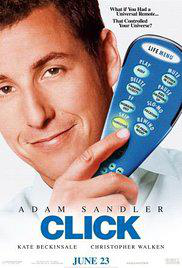

In [131]:
show_image("posters/3662.jpg")

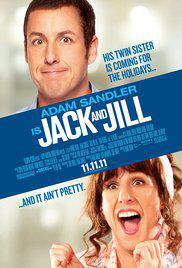

In [132]:
show_image("posters/4098.jpg")

Вырежем первое лицо на каждом постере

In [104]:
def get_first_face(image):
    faces = face_recognition.face_locations(image)
    top, right, bottom, left = faces[0]
    face = image[top:bottom, left:right]
    face_image = Image.fromarray(face)
    return face_image

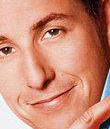

In [105]:
get_first_face(image_3662)

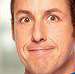

In [106]:
get_first_face(image_4098)

Получим представление для первого лица на каждом постере

In [102]:
enc_3662 = face_recognition.face_encodings(image_3662)[0]
enc_4098 = face_recognition.face_encodings(image_4098)[0]

И посмотрим один и тот же человек или нет

In [103]:
face_recognition.compare_faces([enc_4098],enc_3662)

[True]

**Подсчет процентного числа комедий для имен актёров**  
Если умудриться выделить текст с постера и выделить имена актёров, то можно было бы считать как часто эти имена встречаются в комедиях. Если отделить имена не получится, то можно попробовать считать процентное число комедий по словам.  
Имеет место быть как гипотетически возможный подход

# Что было опробовано, но не нашло место в данном отчёте

**GIST** - если применить его отдельно, то давал 0.6 на кросс-валидации, если же применить в любой из моделей с нейронками, то толку от него ноль  
**Количество белого фона** -- качество хуже чем с выделением основным цветов  
**Использование других реализаций градиентного бустинга** (catboost,xgboost, lightgbm) - где-то лучше, где-то хуже, но вначале нужно было найти оптимальные параметры для каждого, а потом уже сравнивать, что занимает слишком много времени.  
**Попытка нахождения выбросов** - не увенчалась успехом, улучшений не получил   
**Использование других моделей** - все оставшиеся модели из sklearn.ensemble показывали худший результат нежели чем градиентный бустинг. Комбинации knn в стекинге с различным количеством соседей также не дало выхлоп(оптимальное количество -40 или 50). использование pca с knn улучшает результаты knn отдельно, но в стекинге уже не попробовал, т.к это требовало обучения стекинга, который обучается около 4 часов, а в случае подбора параметров с использованием StackingCVClassifier больше 20.

# Дополнение

Есть модель, которая показала неплохие результаты на каком-то кусочке обучающей выборки.  После эта модель была обучена на всей обучающей выборке и была дополнена еще одной моделью(Которая отдельно показала результаты лучше, нежели чем другие модели стекинга). Есть основания полагать, что итоговая модель покажет неплохие результаты на тесте. Но конечно хотелось бы быть более уверенным. 

У google есть функционал поиска по картинкам, но воспользоваться им просто дёргая api не получится.  
Основная идея - **автоматизированный поиск фильмов по картинкам через настоящий браузер**.

Сделаем следующее:   
1. установим selenium и все драйвера для работы с firefox
2. делаем поиск по картинке в google
3. находим и сохраняем ссылку на сайт imdb
4. отдельно проходимся по ссылкам на imdb и сохраняем жанры фильма

In [117]:
import numpy as np
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import os

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd

import time

In [126]:
def get_link_and_name(html):
    bs = BeautifulSoup(html,"lxml")
    google_results = bs.find_all(class_='g')
    for gr in google_results:
        link =  gr.find_all('a')[0]
        if 'http://www.imdb.com/title/' in  link['href']:
            return [link['href'], link.get_text()]
        
def get_search_url(poster_id):
    file_path = 'posters/{0}.jpg'.format(poster_id)
    searchUrl = 'http://www.google.com/searchbyimage/upload'
    multipart = {'encoded_image': (file_path, open(file_path, 'rb')), 'image_content': ''}
    response = requests.post(searchUrl, files=multipart, allow_redirects=False)
    search_url = response.headers['Location']
    
    return search_url

def get_movie(poster_id,google_input_id = 'lst-ib'):
    print('poster_id: ', poster_id)
    #we should get search link. we can do it without selenium
    poster_search_url = get_search_url(poster_id)
    print('poster search url: ',poster_search_url)
    
    #now we can open the search page and find movie
    #here we have to use selenium
    firefox.get(poster_search_url)
    input_field = firefox.find_element_by_id(google_input_id)
    element = WebDriverWait(firefox, 10).until(
        EC.presence_of_element_located((By.ID, "center_col"))
    )
    center_col = firefox.find_element_by_id('center_col')
    search_result_html = center_col.get_attribute('innerHTML')
    
    movie = get_link_and_name(search_result_html)
    if movie:
        result = [poster_id]+movie
        print(result)
        return result
    else:
        #if movie is not found we will add imdb to the search input
        input_field.send_keys(" imdb")
        search_button = firefox.find_element_by_name("btnG")
        search_button.click()
        
        element = WebDriverWait(firefox, 10).until(
            EC.presence_of_element_located((By.ID, "center_col"))
        )
        center_col = firefox.find_element_by_id('center_col')
        search_result_html = center_col.get_attribute('innerHTML')
        
        movie = get_link_and_name(search_result_html)
        if movie:
            result = [poster_id]+movie
            print(result)
            return result
        else:
            return movie

In [124]:
firefox = webdriver.Firefox()
firefox.wait = WebDriverWait(firefox, 5)

#### Пример использования

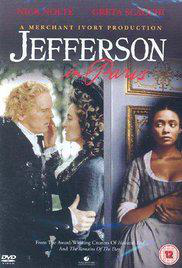

In [133]:
show_image("posters/1.jpg")

In [127]:
get_movie(1)

poster_id:  1
poster search url:  http://www.google.com/search?tbs=sbi:AMhZZivVFY1JM4z4oUfY_1Ny27bF06SWSS3yjNNMWlyfWDx9knTgITwgRnEtjP6YEcx8v6D39KocedfbWhR9OfUQOpC8maATOefXhKUIqByhHPVfqxv5aWmPZxjdorJnQAr_1rZJRRQI1b-BnQI14nMSIE5-DIT5HnV_1ZNAj4JZ1ngxb5eAR95JFtfqB_1tkhKtQUgCuqWEuWN7XNQoQtsysjhJejUccJMbBz9bvK-3Ci11mz6mcmd5vdCFL4WbFAUaCVuNNYADPrOWPS2J8tlL7ej86s0pbL6LJsSlM6daV8ki40KzJ_14xCbtFCLcKeKnqx1G4gr9LmecJ
[1, 'http://www.imdb.com/title/tt0113463/', 'Jefferson in Paris (1995) - IMDb']


[1, 'http://www.imdb.com/title/tt0113463/', 'Jefferson in Paris (1995) - IMDb']

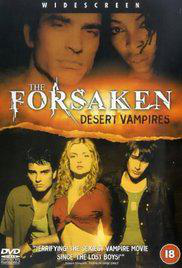

In [134]:
show_image('posters/2.jpg')

In [129]:
get_movie(2)

poster_id:  2
poster search url:  http://www.google.com/search?tbs=sbi:AMhZZivafJYSeAqceYNyXtGvr8nsY_1B2xbT4gvmihNKzkSceJSowwmGR151d7zMdGaXkQgGI1ZHk-CLsxnptlc-z9egKAs72nkjDVE69JSrr_1GSBLuJZJTVPxkIhslD8yQnx2lNnLsWdvqjWpU43vnCtPDTFmG7IynzPabiO5U_1XUuy4ChmNWR80EHumuoiVggVxYPRuiOvbSPlV1sGcA9o6zvaFygK1qnBcqzMoZHq9-j4ibvuw57UTcAOSYaXnAla0_1kxRpDWPk_1FG5g4V3QkozVRwpXsGZpNbC6Y6aSpKUg7r5Lndodr3kx_1D3Rt2tQPBRCBFG9I8
[2, 'http://www.imdb.com/title/tt0245120/', 'The Forsaken (2001) - IMDb']


[2, 'http://www.imdb.com/title/tt0245120/', 'The Forsaken (2001) - IMDb']

**Ограничения google**  
Таким образом получалось вытягивать в среднем 100 фильмов, после чего гугл начинал показывать капчу. Чтобы обойти это ограничение нужно менять ip. 
Самый простой вариант - раздавать интернет с телефона. При переподключении телефона к сети получаем новый ip.

**imdb**  
После того как все ссылки были вытянуты, нужно было пройтись по всем ссылкам и загрузить жанры для каждого фильма. Ссылки не всегда указывали на главную страницу фильма, иногда на какие-то дополнительные. К счастью это решалось простой обрезкой урла.

In [135]:
def cut_url(movie_url):
    start_index = 0
    counter = 5
    if 'http' not in movie_url:
        movie_url='http://'+movie_url
    for i in range(counter):
        start_index = movie_url.find('/', start_index+1)
    return movie_url[:start_index+1]

In [136]:
cut_url('www.imdb.com/title/tt0365957/test/test')

'http://www.imdb.com/title/tt0365957/'

In [137]:
def get_genres_from_imdb(url,titleStoryLineId = 'titleStoryLine'):
    page = urlopen(url).read()
    page_bs = BeautifulSoup(page,'lxml')
    storyline = page_bs.select("#{0}".format(titleStoryLineId))[0]
    genres = [a.get_text().strip() for a in storyline.select('div[itemprop="genre"]')[0].find_all('a')]
    return genres

In [138]:
get_genres_from_imdb('http://www.imdb.com/title/tt0113463/')

['Biography', 'Drama', 'History', 'Romance']

Затем нужно было проверить ответы которые получились. Для этого сравнивались названия фильмов в итоговом файле с названием фильма на постере. Было обнаружено около 50 ошибок. На исправление ушло около четырёх часов. Скорее всего в получившемся файле были еще какие-то ошибки, но это не столь важно, т.к полученных данных хватит чтобы оценить конечную модель. 

В итоге получился следующий файл

In [151]:
imdb_test = pd.read_csv('imdb_test.csv')
test_y=imdb_test['Comedy']

imdb_test.head(5)

,Id,Title,Url2,Action,Adventure,Animation,Biography,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,Comedy
0,3636,Love Me Tender (1956) - IMDb,http://www.imdb.com/title/tt0049452/,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3637,Doomsday (2008) - IMDb,http://www.imdb.com/title/tt0483607/,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,3638,Charlie Bartlett (2007) - IMDb,http://www.imdb.com/title/tt0423977/,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,3639,Kiss the Girls (1997) - IMDb,http://www.imdb.com/title/tt0119468/,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,3640,Renaissance (2006) - IMDb,http://www.imdb.com/title/tt0386741/,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


Теперь посмотрим на результаты на тесте

In [148]:
answer = final_sclf.predict_proba(full_test_data)[:,1]

In [149]:
roc_auc_score(test_y, answer)

0.92238775613972657

In [154]:
result = pd.DataFrame({'Id':test_id,'Probability':answer})

In [156]:
result.to_csv('{0}_task_2_prediction.csv'.format(username))

# Заключение

Конечно, когда я получил ответы на тесте и посчитал roc_auc итоговой модели, я не удержался и несколько модифицировал параметры(например количество деревьев в модели первого слоя), дабы улучшить результаты на тестовой выборке. 
К сожалению, я не успел сделать кросс-валидацию на обучающей выборке и есть подозрения, что я непреднамеренно переобучился на тестовую выборку(Например, когда настроил количество деревьев в модели первого слоя).  

Тем не менее, надеюсь, что ценность проделанной работы от этого не падает.  